# Direct compression examples

In this notebook we will show how to perform full shape fits to data power spectrum, using Taylor expansion to speed up likelihood evaluation.
Look first at notebooks basic_examples.ipynb to get a flavor of *desilike* mechanisms.

## Fake power spectrum data

In [5]:
#Fake power spectrum data
import numpy as np
from matplotlib import pyplot as plt

from cosmoprimo.fiducial import DESI

#---Preparation of cosmology and k bins---
cosmo = DESI()                       #Cosmology object with fiducial DESI values
edges = np.linspace(0., 0.3, 31)     #Edges of k bins: 31 points -> 30 linear bins between 0 and 0.3
k = (edges[:-1] + edges[1:]) / 2.    #k: center of each bin (length = 30)
#nmodes: k-space volume of each shell: (4π/3)*(k_max^3 - k_min^3)
nmodes = 4. * np.pi / 3. * (edges[1:]**3 - edges[:-1]**3)

z = 1.                                #redshift where evaluated

#---Get Fourier-related utilities and P(k)---
fo = cosmo.get_fourier()              #Fourier utilities from the cosmology object
#pk_interpolator(of='delta_cb') returns a function that takes (k, z=...) and returns P_delta_cb(k,z)
pk = fo.pk_interpolator(of='delta_cb')(k, z=z)

#Linear bias and growth-related factor
b = 2.                                 #linear bias of the tracer
#f is constructed via the ratio of sigma8 for theta and delta; useful approximation here
f = fo.sigma8_z(z, of='theta_cb') / fo.sigma8_z(z, of='delta_cb')

#Shot noise and survey volume (arbitrary numbers for mocks)
shotnoise = 1 / 5e-4
volume = 1e10

#---Build multipoles (ℓ = 0,2,4) using the linear Kaiser formula---
ells = (0, 2, 4)
poles = []
#monopole (ℓ=0): (b^2 + 2/3 f b + 1/5 f^2) * P(k) + shotnoise
poles.append((b**2 + 2. / 3. * f * b + 1. / 5. * f**2) * pk + shotnoise)
#quadrupole (ℓ=2): (4/3 f b + 4/7 f^2) * P(k)
poles.append((4. / 3. * f * b + 4. / 7. * f**2) * pk)
#hexadecapole (ℓ=4): 8/35 f^2 * P(k)
poles.append(8. / 35 * f**2 * pk)
#Convert to array with dtype float64; final shape (3, len(k))
poles = np.array(poles, dtype='f8')

from pypower import PowerSpectrumStatistics
#PowerSpectrumStatistics(edges, k, poles, ...) packages the multipoles into a structure per bin
mean = PowerSpectrumStatistics(edges, k, poles, nmodes=nmodes, ells=ells,
                               shotnoise_nonorm=shotnoise, statistic='multipole')

#---Build a simplified diagonal covariance (Gaussian approximation)---
#For each ell use the form 2*(2π)^3 / ((2ℓ+1)*V*nmodes) * P^2 (here using monopole^2 as simplification)
cov = [2. * (2. * np.pi)**3 / (2 * ell + 1) / (volume * nmodes) * poles[0]**2 for ell in ells]
#cov is a list of arrays (one per ell); concatenate and form diagonal matrix
cov = np.diag(np.concatenate(cov, axis=0))

#---Generate Gaussian mocks---
rng = np.random.RandomState(seed=42)  #reproducible RNG
mocks = []
for i in range(1000):
    tmp = mean.deepcopy()  #copy of the mean object (data structure)
    #Sample multivariate normal with mean = mean.power_nonorm.ravel() and covariance = cov
    #and assign to tmp.power_nonorm (vectorized)
    tmp.power_nonorm.flat[...] = rng.multivariate_normal(mean.power_nonorm.ravel(), cov)
    mocks.append(tmp)

#Take one mock as "data" and the rest as "mocks"
data, mocks = mocks[0], mocks[1:]

## Direct likelihood

In [6]:
from desilike.theories.galaxy_clustering import DirectPowerSpectrumTemplate, KaiserTracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike.parameter import ParameterCollection
from desilike import setup_logging


template = DirectPowerSpectrumTemplate(z=z, fiducial='DESI')
#Build a power spectrum template at redshift z, using DESI fiducial cosmology

for param in ['omega_b', 'n_s']:
    template.params[param].update(fixed=True)
#Fix baryon density (omega_b) and scalar index (n_s) so they are not varied in the fit

theory = KaiserTracerPowerSpectrumMultipoles(template=template)
#Define theory model for multipoles of P(k) in redshift space using the Kaiser approximation

theory.params['b1'].update(value=2.)
#Set the linear bias parameter b1 to 2

observable = TracerPowerSpectrumMultipolesObservable(
    data=data, covariance=mocks,
    klim={0: [0.02, 0.2], 2: [0.02, 0.2]}, #Fit monopole (ℓ=0) and quadrupole (ℓ=2) in the k-range [0.02,0.2] h/Mpc
    theory=theory
)
#Define the observable: compare mock data with theory model using given covariance

likelihood = ObservablesGaussianLikelihood(observables=[observable])
#Build a Gaussian likelihood function from the observable to be used in parameter inference




# NOTE: if we wanted to fit xi instead:
# theory = KaiserTracerCorrelationFunctionMultipoles(template=template)
# observable = ObservedTracerCorrelationFunction(data=data, covariance=mocks,
#                                                slim={0: [40., 160], 2: [40., 160]}, # fit monopole and quadrupole, between 0.02 and 0.2 h/Mpc
#                                                theory=theory)
# The rest would be the same

setup_logging()
likelihood()  # just to initialize

[000000.25] [0/1] 09-15 21:26  ObservablesGaussianLikelihood INFO     Covariance matrix with 36 points built from 999 observations.
[000000.25] [0/1] 09-15 21:26  ObservablesGaussianLikelihood INFO     ...resulting in a Hartlap 2007 factor of 0.9629.
[000006.26] [0/1] 09-15 21:26  ObservablesGaussianLikelihood INFO     Covariance matrix with 36 points built from 999 observations, varying 5 parameters.
[000006.26] [0/1] 09-15 21:26  ObservablesGaussianLikelihood INFO     ...resulting in a Percival 2014 factor of 1.0259.


Array(-16.84138601, dtype=float64)

[000117.53] [0/1] 09-15 21:28  Emulator                  INFO     Varied parameters: ['h', 'omega_cdm', 'logA', 'b1', 'sn0'].
[000117.53] [0/1] 09-15 21:28  Emulator                  INFO     Found varying ['power'] and fixed ['k', 'z', 'ells', 'nd'] outputs.
[000118.99] [0/1] 09-15 21:28  Differentiation           INFO     Varied parameters: ['h', 'omega_cdm', 'logA', 'b1', 'sn0'].
[000126.49] [0/1] 09-15 21:28  Differentiation           INFO     Using finite-differentiation for parameter h.
[000128.00] [0/1] 09-15 21:28  Differentiation           INFO     Using finite-differentiation for parameter omega_cdm.
[000129.51] [0/1] 09-15 21:28  Differentiation           INFO     Using finite-differentiation for parameter logA.
[000129.52] [0/1] 09-15 21:28  Differentiation           INFO     Using auto-differentiation for parameter b1.
[000129.52] [0/1] 09-15 21:28  Differentiation           INFO     Using auto-differentiation for parameter sn0.
[000129.52] [0/1] 09-15 21:28  Differentiati

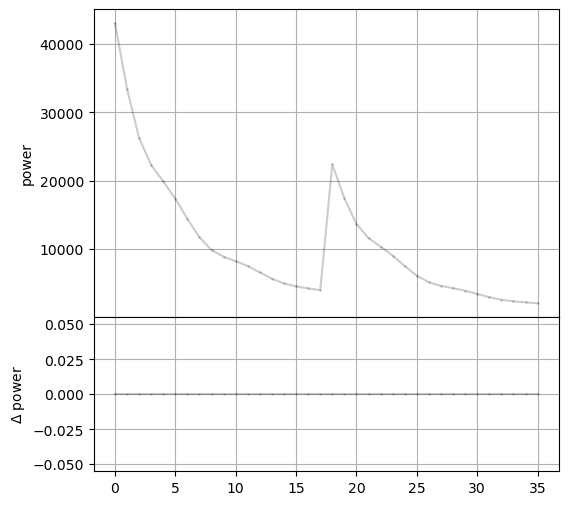

In [7]:
from desilike.emulators import Emulator, EmulatedCalculator, TaylorEmulatorEngine

#Create an emulator for the theory model using a Taylor expansion engine
#order={'*': 2, 'sn0': 1} means: quadratic expansion for all parameters, except 'sn0' which uses linear
emulator = Emulator(theory, engine=TaylorEmulatorEngine(order={'*': 2, 'sn0': 1}))

#Generate training samples of the theory model (evaluate the model at different parameter points)
emulator.set_samples()

#Fit the Taylor expansion to the sampled data (build the emulator)
emulator.fit()

#Plot emulator predictions vs original model for quick validation
emulator.plot(name='power')

import os
base_dir = '_tests'
kaiser_emulator_fn = os.path.join(base_dir, 'kaiser_emulator.npy')

#Save the trained emulator to disk as a .npy file
emulator.save(kaiser_emulator_fn)

## Sampling
Let us draw MC samples of the likelihood (actually posterior, including parameter priors).

In [4]:
from desilike.samplers import ZeusSampler

# Let's just update the observable's theory, no need to redefine the observable & likelihood
# (Internally the code will reinitialize all calculators that depend on observable)
observable.init.update(theory=emulator.to_calculator())

sampler = ZeusSampler(likelihood, save_fn='_tests/chain_fs_direct_*.npy', seed=42)
sampler.run(check={'max_eigen_gr': 0.1})

[000063.44] [0/1] 09-15 20:51  ObservablesGaussianLikelihood INFO     Covariance matrix with 36 points built from 999 observations.
[000063.44] [0/1] 09-15 20:51  ObservablesGaussianLikelihood INFO     ...resulting in a Hartlap 2007 factor of 0.9629.
[000063.45] [0/1] 09-15 20:51  ZeusSampler               INFO     Varied parameters: ['h', 'omega_cdm', 'logA', 'b1', 'sn0'].
[000064.14] [0/1] 09-15 20:51  ObservablesGaussianLikelihood INFO     Covariance matrix with 36 points built from 999 observations, varying 5 parameters.
[000064.14] [0/1] 09-15 20:51  ObservablesGaussianLikelihood INFO     ...resulting in a Percival 2014 factor of 1.0259.
[000064.53] [0/1] 09-15 20:51  ZeusSampler               INFO     Successfully vmap input likelihood.
[000064.67] [0/1] 09-15 20:51  ZeusSampler               INFO     Successfully jit input likelihood.
[000064.86] [0/1] 09-15 20:51  root                      INFO     Initialising ensemble of 12 walkers...
[000082.86] [0/1] 09-15 20:52  Chain     

[Chain(shape=(1200, 12), params=ParameterCollection(['h', 'omega_cdm', 'logA', 'b1', 'sn0', 'logposterior', 'omega_b', 'n_s', 'tau_reio', 'm_ncdm', 'N_eff', 'w0_fld', 'wa_fld', 'Omega_k', 'sigmapar', 'sigmaper', 'loglikelihood', 'logprior']))]

[000221.06] [0/1] 09-15 21:30  ObservablesGaussianLikelihood INFO     Covariance matrix with 36 points built from 999 observations.
[000221.06] [0/1] 09-15 21:30  ObservablesGaussianLikelihood INFO     ...resulting in a Hartlap 2007 factor of 0.9629.
[000221.07] [0/1] 09-15 21:30  ObservablesGaussianLikelihood INFO     Covariance matrix with 36 points built from 999 observations, varying 5 parameters.
[000221.07] [0/1] 09-15 21:30  ObservablesGaussianLikelihood INFO     ...resulting in a Percival 2014 factor of 1.0259.


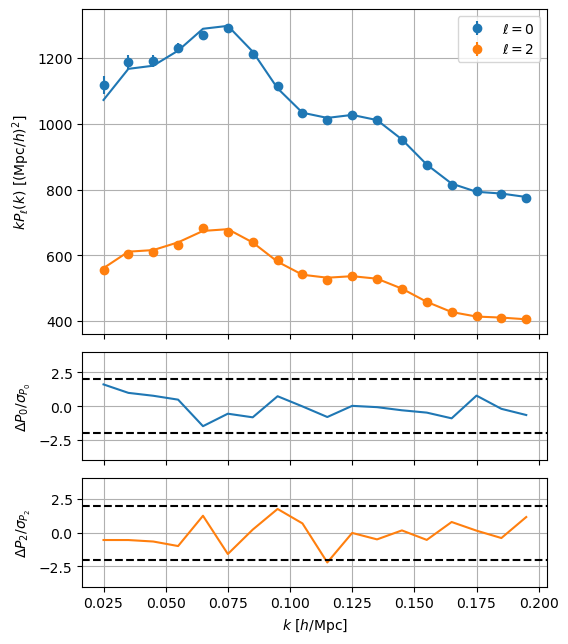

In [8]:
#Lets print the bestfit prediction vs the fake data
likelihood(**sampler.chains[0].choice(params=likelihood.varied_params))
observable.plot()
plt.show()

In [9]:
#Print the stats for the chain (50% burnin removed)
chain = sampler.chains[0].remove_burnin(0.5)
print(chain.to_stats(tablefmt='pretty'))

+-----------+---------+---------+---------+---------+-----------------+-----------------+
|           | argmax  |  mean   | median  |   std   | quantile:1sigma | interval:1sigma |
+-----------+---------+---------+---------+---------+-----------------+-----------------+
|     h     | 0.6775  | 0.6772  | 0.6774  | 0.0053  | -0.0053/+0.0052 | -0.0050/+0.0055 |
| omega_cdm | 0.11998 | 0.11987 | 0.11986 | 0.00087 | -8.4e-4/+8.8e-4 | -8.4e-4/+8.8e-4 |
|   logA    |  3.038  |  3.040  |  3.040  |  0.014  |  -0.014/+0.014  |  -0.013/+0.015  |
|    b1     |  1.988  |  1.987  |  1.987  |  0.012  |  -0.012/+0.012  |  -0.012/+0.012  |
|    sn0    | 0.0021  | 0.0022  | 0.0021  | 0.0031  | -0.0032/+0.0032 | -0.0036/+0.0027 |
+-----------+---------+---------+---------+---------+-----------------+-----------------+


# Plotting
(See the 'plotting_examles.ipynb' file for details)

Removed no burn in


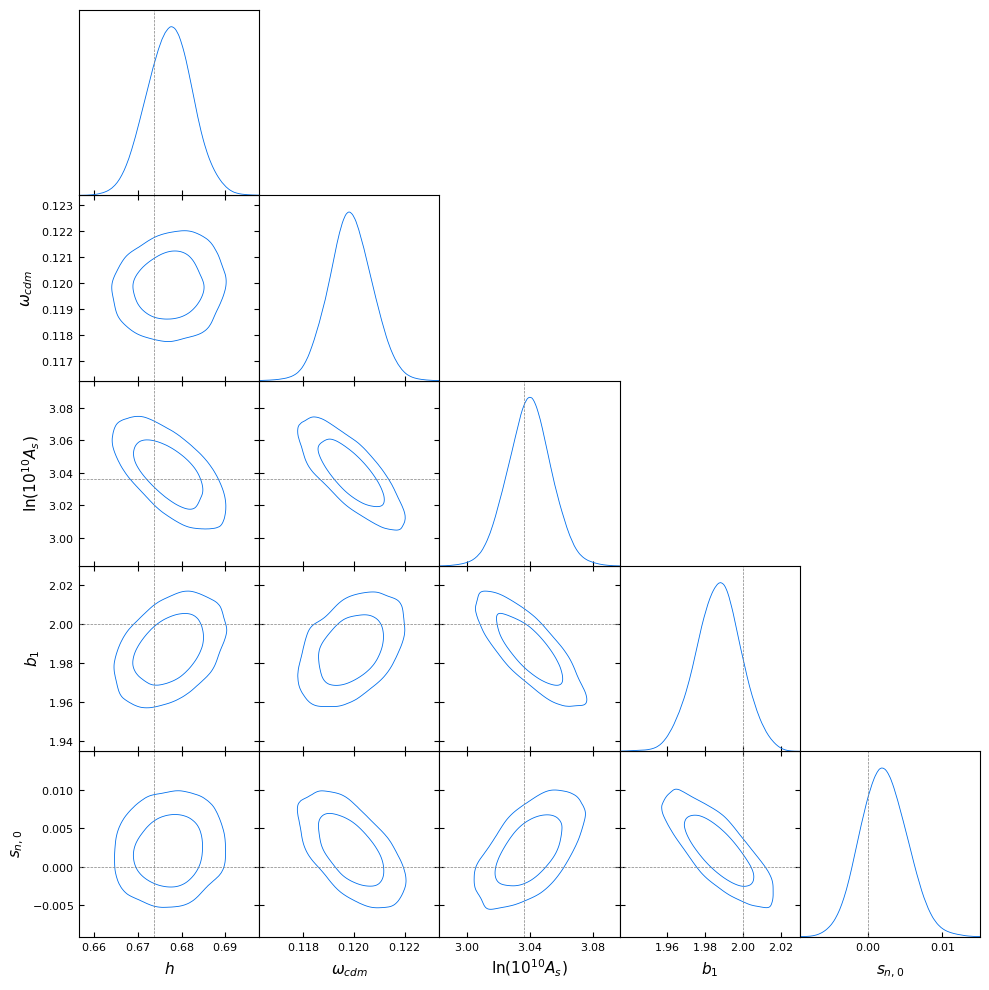

In [7]:
from desilike.samples import plotting
plotting.plot_triangle(chain, markers={'Omega_m': cosmo.Omega0_m, 'h': cosmo.h, 'logA': np.log(10**10 * cosmo.A_s), 'n_s': cosmo.n_s, 'b1': b, 'sn0': 0.})